In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import os

In [2]:
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./images\N1.xml,1093,1396,645,727
1,./images\N100.xml,134,301,312,350
2,./images\N101.xml,31,139,128,161
3,./images\N102.xml,164,316,216,243
4,./images\N103.xml,813,1067,665,724


In [3]:
import xml.etree.ElementTree as xet

In [4]:
def getFileName(filepath):
    filename_image=xet.parse(filepath).getroot().find('filename').text
    filepath_image=os.path.join('./images',filename_image)
    return filepath_image

In [5]:
image_path=list(df['filepath'].apply(getFileName))

In [6]:
image_path

['./images\\N1.jpeg',
 './images\\N100.jpeg',
 './images\\N101.jpeg',
 './images\\N102.jpeg',
 './images\\N103.jpeg',
 './images\\N104.jpeg',
 './images\\N105.jpeg',
 './images\\N106.jpeg',
 './images\\N107.jpeg',
 './images\\N108.jpeg',
 './images\\N109.jpeg',
 './images\\N11.jpeg',
 './images\\N110.jpeg',
 './images\\N111.jpeg',
 './images\\N112.jpeg',
 './images\\N113.jpeg',
 './images\\N114.jpeg',
 './images\\N116.jpeg',
 './images\\N117.jpeg',
 './images\\N118.jpeg',
 './images\\N119.jpeg',
 './images\\N12.jpeg',
 './images\\N120.jpeg',
 './images\\N121.jpeg',
 './images\\N122.jpeg',
 './images\\N123.jpeg',
 './images\\N124.jpeg',
 './images\\N126.jpeg',
 './images\\N127.jpeg',
 './images\\N128.jpeg',
 './images\\N129.jpeg',
 './images\\N130.jpeg',
 './images\\N131.jpeg',
 './images\\N132.jpeg',
 './images\\N133.jpeg',
 './images\\N134.jpeg',
 './images\\N135.jpeg',
 './images\\N136.jpeg',
 './images\\N137.jpeg',
 './images\\N138.jpeg',
 './images\\N139.jpeg',
 './images\\N14.jpeg

In [7]:
# verify the bounding box
image=image_path[0]
img=cv2.imread(image)
cv2.rectangle(img,(1093,645),(1396,727),(0,255,0),5)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [9]:
labels=df.iloc[:,1:].values


In [10]:
data =[]
output=[]
for ind in range (len(image_path)):
    image = image_path[ind]
    image_arr=cv2.imread(image)
    h,w,d=image_arr.shape
    
    # preprocessing
    
    load_image=load_img(image,target_size=(224,224))
    load_image_arr=img_to_array(load_image)
    norm_load_image_array=load_image_arr/255.0 # normalized input 
    
    # normalizing the labels
    
    xmin,xmax,ymin,ymax=labels[ind]
    nxmin,nxmax=xmin/w,xmax/w
    nymin,nymax=ymin/h,ymax/h
    
    label_norm= (nxmin,nxmax,nymin,nymax) # normalized output 
    
    # append the normalized data 
    data.append(norm_load_image_array)
    output.append(label_norm)
    
    

In [11]:
X=np.array(data,dtype=np.float32)
y=np.array(output,dtype=np.float32)

In [12]:
X.shape, y.shape

((225, 224, 224, 3), (225, 4))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [14]:
from tensorflow.keras.applications import MobileNetV2,InceptionV3,InceptionResNetV2
from tensorflow.keras.layers import Dense,Dropout,Flatten,Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [15]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False

# building custom top 

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(512,activation="relu")(headmodel)
headmodel = Dense(256,activation="relu")(headmodel)
headmodel = Dense(64,activation="relu")(headmodel)
headmodel = Dense(4,activation="sigmoid")(headmodel)

# model 
model = Model(inputs=inception_resnet.input,outputs=headmodel)



In [16]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 25, 25, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 25, 25, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 25, 25, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 25, 25, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 25, 25, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 25, 25, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 25, 25, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 25, 25, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 25, 25, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 25, 25, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 25, 25, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 25, 25, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 25, 25, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 25, 25, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 25, 25, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 12, 12, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 12, 12, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 12, 12, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 12, 12, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 12, 12, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 12, 12, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 12, 12, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 12, 12, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 12, 12, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 12, 12, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 12, 12, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 12, 12, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 12, 12, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 12, 12, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 12, 12, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 12, 12, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 12, 12, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 12, 12, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 12, 12, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 12, 12, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 12, 12, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 12, 12, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 12, 12, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 12, 12, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 12, 12, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 12, 12, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 12, 12, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 5, 5, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 5, 5, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 5, 5, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 5, 5, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 5, 5, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 5, 5, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 5, 5, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 5, 5, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 5, 5, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 5, 5, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 5, 5, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 5, 5, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 5, 5, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 5, 5, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 5, 5, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 5, 5, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 5, 5, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 flatten (Flatten)              (None, 38400)        0           ['conv_7b_ac[0][0]']             
                                                                                                  
 dense (Dense)                  (None, 512)          19661312    ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          131328      ['dense[0][0]']                  
                                                                                                  
 dense_2 (

In [17]:
from tensorflow.keras.callbacks import TensorBoard
tfb= TensorBoard('Object Detection ')

In [18]:
history = model.fit(x=X_train,y=y_train, batch_size = 25 , epochs=100 , validation_data=(X_test,y_test))

Epoch 1/100
8/8 [==============================] - 29s 3s/step - loss: 0.0609 - val_loss: 0.0532
Epoch 2/100
8/8 [==============================] - 19s 2s/step - loss: 0.0303 - val_loss: 0.0225
Epoch 3/100
8/8 [==============================] - 19s 2s/step - loss: 0.0166 - val_loss: 0.0203
Epoch 4/100
8/8 [==============================] - 19s 2s/step - loss: 0.0124 - val_loss: 0.0177
Epoch 5/100
8/8 [==============================] - 19s 2s/step - loss: 0.0125 - val_loss: 0.0109
Epoch 6/100
8/8 [==============================] - 19s 2s/step - loss: 0.0074 - val_loss: 0.0102
Epoch 7/100
8/8 [==============================] - 19s 2s/step - loss: 0.0071 - val_loss: 0.0082
Epoch 8/100
8/8 [==============================] - 19s 2s/step - loss: 0.0060 - val_loss: 0.0107
Epoch 9/100
8/8 [==============================] - 19s 2s/step - loss: 0.0045 - val_loss: 0.0096
Epoch 10/100
8/8 [==============================] - 19s 2s/step - loss: 0.0041 - val_loss: 0.0083
Epoch 11/100
8/8 [===========

Epoch 84/100
8/8 [==============================] - 20s 3s/step - loss: 7.5247e-04 - val_loss: 0.0073
Epoch 85/100
8/8 [==============================] - 20s 3s/step - loss: 9.8379e-04 - val_loss: 0.0073
Epoch 86/100
8/8 [==============================] - 20s 3s/step - loss: 9.8243e-04 - val_loss: 0.0075
Epoch 87/100
8/8 [==============================] - 21s 3s/step - loss: 8.5234e-04 - val_loss: 0.0067
Epoch 88/100
8/8 [==============================] - 21s 3s/step - loss: 5.4327e-04 - val_loss: 0.0065
Epoch 89/100
8/8 [==============================] - 21s 3s/step - loss: 4.2078e-04 - val_loss: 0.0074
Epoch 90/100
8/8 [==============================] - 21s 3s/step - loss: 7.2545e-04 - val_loss: 0.0077
Epoch 91/100
8/8 [==============================] - 20s 2s/step - loss: 8.4647e-04 - val_loss: 0.0069
Epoch 92/100
8/8 [==============================] - 19s 2s/step - loss: 8.4163e-04 - val_loss: 0.0071
Epoch 93/100
8/8 [==============================] - 20s 2s/step - loss: 6.8018e-04

In [20]:
model.save('./models/object_detection.h5')

<AxesSubplot:>

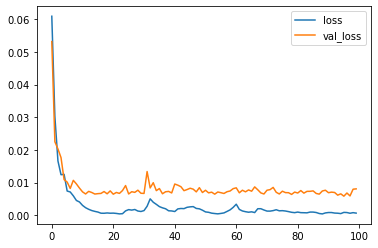

In [21]:
model_loss=pd.DataFrame(model.history.history)
model_loss.plot()